# Text-based nutrient estimation model

We can approach this problem using NLP (Natural Language Processing) and machine learning techniques.

In [3]:
import pandas as pd
import numpy as np

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from gensim.models import Word2Vec

import spacy
import pandas as pd
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib


### Load Data

In [5]:
path = 'clean_data_with_same_units.csv'
df = pd.read_csv(path, index_col=0)

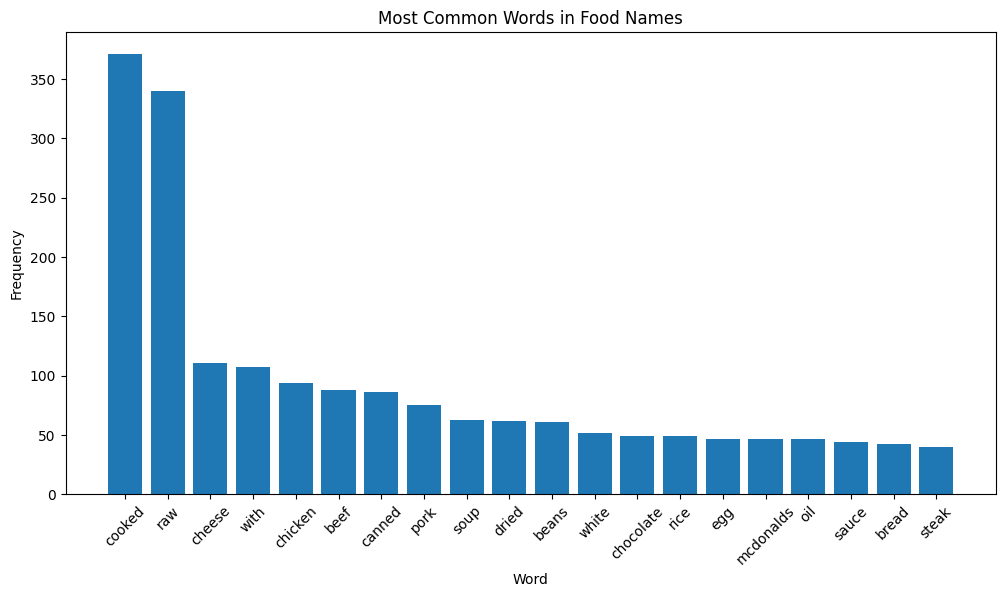

In [6]:
words = df['food'].str.lower().str.split().sum()

# Count word occurrences
word_counts = Counter(words)
common_words = word_counts.most_common(20)  # Top 20 most frequent words

# Visualize
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words in Food Names')
plt.show()

In [7]:
# Function to get average nutrient values for a word
def avg_nutrient_for_word(word, df):
    subset = df[df['food'].str.contains(word, case=False)]
    return subset.drop(columns=['food']).mean()

# Just for exploring the dataset -  Compare "cheese" and "cream"
cheese_nutrients = avg_nutrient_for_word('cheese', df)
cream_nutrients = avg_nutrient_for_word('cream', df)

print("Average Nutrient Values for 'Cheese':\n", cheese_nutrients)
print("Average Nutrient Values for 'Cream':\n", cream_nutrients)

Average Nutrient Values for 'Cheese':
 Caloric Value             272.586207
Fat                     16690.517241
Saturated Fats           8187.068966
Monounsaturated Fats     5323.198276
Polyunsaturated Fats     1897.784483
Carbohydrates           17456.112069
Sugars                   2006.586207
Protein                 13741.379310
Dietary Fiber             819.103448
Cholesterol                55.413793
Sodium                      0.606595
Water                   55612.931034
Vitamin A                   0.000125
Vitamin B1                  0.145328
Vitamin B11                 0.059647
Vitamin B12                 0.046948
Vitamin B2                  0.264181
Vitamin B3                  1.518164
Vitamin B5                  0.650224
Vitamin B6                  0.135983
Vitamin C                   2.324457
Vitamin D                   0.114897
Vitamin E                   0.274172
Vitamin K                   0.104000
Calcium                   257.445440
Copper                     12.521759

### Supervised Learning

Caloric Value is easy to find (on food packaging, online, or from databases like USDA).\
Nutrition Density is harder to measure because it depends on multiple nutrients, and it's not always printed on food labels.\
Thus, `Nutrition Density` will be our **Target Variable**

In [10]:
# Set Target Variable
nutrient_target = df["Nutrition Density"] # Set target to Nutrition Density

In [11]:
# Option 1: Use all Nutrients
nutrient_all_features = df.drop(columns=["food", "Nutrition Density"])

In [12]:
# Option 2: Macronutrients Only 
nutrient_macronutrient_features = df[["Fat", "Saturated Fats", "Carbohydrates", "Protein", "Sugars", "Dietary Fiber"]]

In [13]:
# Minerals Only
nutrient_mineral_features = df[["Calcium", "Iron", "Magnesium", "Manganese", "Phosphorus", "Potassium", "Selenium", "Zinc", "Copper"]]

In [14]:
# Vitamins Only
nutrient_vitamin_features = df[["Vitamin A", "Vitamin B1", "Vitamin B11", "Vitamin B12", "Vitamin B2", "Vitamin B3",
                                "Vitamin B5", "Vitamin B6", "Vitamin C", "Vitamin D", "Vitamin E", "Vitamin K"]]

In [15]:
# Dictionary to store results
results = {}

# Try each feature set
feature_sets = {
    "All Nutrients": nutrient_all_features,
    "Macronutrients": nutrient_macronutrient_features,
    "Minerals": nutrient_mineral_features,
    "Vitamins": nutrient_vitamin_features
}

for name, nutrient_features in feature_sets.items():
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(nutrient_features, nutrient_target, test_size=0.2, random_state=42)

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict
    rf_predictions = rf.predict(X_test)

    # Evaluate
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)

    # Store results
    results[name] = {"MAE": rf_mae, "R² Score": rf_r2}

    print(f"\n Results for {name}:")
    print(f"   - MAE: {rf_mae:.4f}")
    print(f"   - R² Score: {rf_r2:.4f}")



 Results for All Nutrients:
   - MAE: 9.9038
   - R² Score: 0.9507

 Results for Macronutrients:
   - MAE: 47.5109
   - R² Score: 0.6568

 Results for Minerals:
   - MAE: 24.7728
   - R² Score: 0.8942

 Results for Vitamins:
   - MAE: 48.0341
   - R² Score: 0.6937


In [16]:
# Choose the best feature set (All Nutrients performed best)
best_feature_set = nutrient_all_features  

# Train Random Forest again on the best feature set
rf_best = RandomForestRegressor(n_estimators=100, random_state=42)
rf_best.fit(best_feature_set, nutrient_target)

# Get feature importance scores
importances = rf_best.feature_importances_
feature_names = best_feature_set.columns

# Sort features by importance
important_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the important features
for feature, importance in important_features[:15]:
    print(f"{feature}: {importance:.4f}")

Calcium: 0.6450
Vitamin C: 0.2025
Caloric Value: 0.0727
Carbohydrates: 0.0070
Potassium: 0.0064
Saturated Fats: 0.0056
Phosphorus: 0.0055
Water: 0.0054
Fat: 0.0041
Dietary Fiber: 0.0037
Vitamin B2: 0.0037
Selenium: 0.0036
Iron: 0.0034
Vitamin B5: 0.0034
Zinc: 0.0033


In [17]:
# Define the top 15 features
top_15_nutrient_features = ["Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
                            "Potassium", "Saturated Fats", "Phosphorus", "Water",
                            "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
                            "Iron", "Vitamin B5", "Zinc"]

# Extract only these features
nutrient_best_15_features = df[top_15_nutrient_features]

# Define the target variable (Nutrition Density)
nutrient_target = df["Nutrition Density"]

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(nutrient_best_15_features, nutrient_target, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_best_15 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_best_15.fit(X_train, y_train)

# Predict on test data
rf_predictions_15 = rf_best_15.predict(X_test)

# Evaluate performance
rf_mae_15 = mean_absolute_error(y_test, rf_predictions_15)
rf_r2_15 = r2_score(y_test, rf_predictions_15)

print(f"\n Using Only Top 15 Features:")
print(f"   - MAE: {rf_mae_15:.4f}")
print(f"   - R² Score: {rf_r2_15:.4f}")



 Using Only Top 15 Features:
   - MAE: 9.4282
   - R² Score: 0.9557


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=2)
rf_random.fit(X_train, y_train)

# Best parameters
print(rf_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


In [20]:
# Train optimized Random Forest model
rf_optimized = RandomForestRegressor(
    n_estimators=300, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_depth=30,
    random_state=42
)

rf_optimized.fit(X_train, y_train)

# Predict on test data
rf_predictions_optimized = rf_optimized.predict(X_test)

# Evaluate performance
rf_mae_optimized = mean_absolute_error(y_test, rf_predictions_optimized)
rf_r2_optimized = r2_score(y_test, rf_predictions_optimized)

print(f"\n Optimized Random Forest Results:")
print(f"   - MAE: {rf_mae_optimized:.4f}")
print(f"   - R² Score: {rf_r2_optimized:.4f}")

#  Save the trained optimized model
import joblib
joblib.dump(rf_optimized, "/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/nutrition_density_optimized.pkl")

print("\n Optimized Model Saved Successfully!")



 Optimized Random Forest Results:
   - MAE: 9.4115
   - R² Score: 0.9561

 Optimized Model Saved Successfully!


## NLP

In [87]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

### Lemmatize Food Names

In [70]:
def lemmatize_food_name(food_name):
    """Lemmatize food names without removing any words."""
    doc = nlp(food_name.lower())  # Convert to lowercase and process with spaCy
    return " ".join([token.lemma_ for token in doc])  # Join lemmatized words

# Apply lemmatization
df["clean_food"] = df["food"].apply(lemmatize_food_name)

# Check result
df[["food", "clean_food"]].head(10)

,food,clean_food
0,cream cheese,cream cheese
1,neufchatel cheese,neufchatel cheese
2,requeijao cremoso light catupiry,requeijao cremoso light catupiry
3,ricotta cheese,ricotta cheese
4,cream cheese low fat,cream cheese low fat
5,cream cheese fat free,cream cheese fat free
6,gruyere cheese,gruyere cheese
7,cheddar cheese,cheddar cheese
8,parmesan cheese,parmesan cheese
9,romano cheese,romano cheese


### Convert Food Names into Features

Machine learning models cannot process text directly, so we need to convert food names into numerical representations.

Before proceeding, let's remove "food" and keep only "clean_food":

In [75]:
# Drop original food name column
df = df.drop(columns=["food"])

print(df.head())

   Unnamed: 0  Caloric Value    Fat  Saturated Fats  Monounsaturated Fats  \
0           0             51   5000            2900                  1300   
1           1            215  19400           10900                  4900   
2           2             49   3600            2300                   900   
3           3             30   2000            1300                   500   
4           4             30   2300            1400                   600   

   Polyunsaturated Fats  Carbohydrates  Sugars  Protein  Dietary Fiber  ...  \
0                   200            800     500      900              0  ...   
1                   800           3100    2700     7800              0  ...   
2                     0            900    3400      800            100  ...   
3                     2           1500      91     1500              0  ...   
4                    42           1200     900     1200              0  ...   

    Iron  Magnesium  Manganese  Phosphorus  Potassium  Seleniu

In [77]:
df["tokenized_food"] = df["clean_food"].apply(lambda x: x.split())
print(df[["clean_food", "tokenized_food"]].head(10))

                         clean_food                         tokenized_food
0                      cream cheese                        [cream, cheese]
1                 neufchatel cheese                   [neufchatel, cheese]
2  requeijao cremoso light catupiry  [requeijao, cremoso, light, catupiry]
3                    ricotta cheese                      [ricotta, cheese]
4              cream cheese low fat              [cream, cheese, low, fat]
5             cream cheese fat free             [cream, cheese, fat, free]
6                    gruyere cheese                      [gruyere, cheese]
7                    cheddar cheese                      [cheddar, cheese]
8                   parmesan cheese                     [parmesan, cheese]
9                     romano cheese                       [romano, cheese]


In [77]:
# Train Word2Vec on tokenized food names
word2vec_model = Word2Vec(sentences=df["tokenized_food"], vector_size=50, window=10, min_count=2, workers=4)

# Find similar words
print(word2vec_model.wv.most_similar("cheese"))
print(word2vec_model.wv.most_similar("cream"))

[('cook', 0.6889477372169495), ('raw', 0.6664519309997559), ('chicken', 0.653892993927002), ('fat', 0.5897331833839417), ('cracker', 0.5842329263687134), ('roast', 0.5737271904945374), ('bread', 0.557746946811676), ('with', 0.5520036816596985), ('kentucky', 0.5371696949005127), ('mcdonald', 0.5366818904876709)]
[('dry', 0.5703052878379822), ('sauce', 0.5593373775482178), ('cook', 0.5293482542037964), ('can', 0.5286263823509216), ('raw', 0.5205620527267456), ('raisin', 0.48381611704826355), ('roast', 0.4827699363231659), ('rice', 0.4780230224132538), ('in', 0.4763299524784088), ('coffee', 0.4655608832836151)]


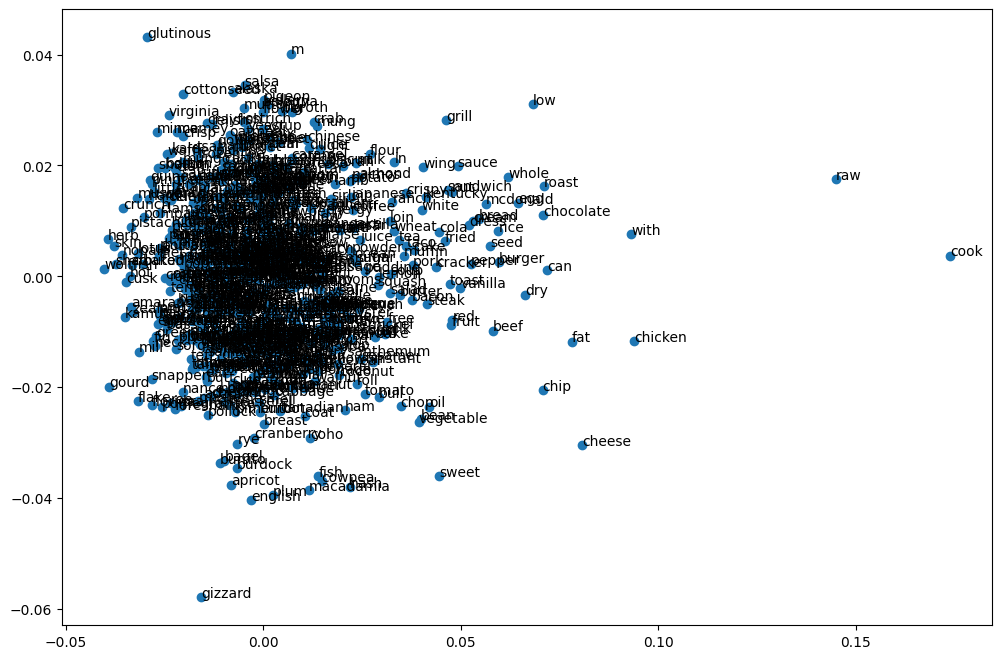

In [79]:
# Get embeddings for words
words = list(word2vec_model.wv.index_to_key)
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Reduce dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Plot words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

plt.show()

In [79]:
df["tokenized_food"]

0                             [cream, cheese]
1                        [neufchatel, cheese]
2       [requeijao, cremoso, light, catupiry]
3                           [ricotta, cheese]
4                   [cream, cheese, low, fat]
                        ...                  
2390                              [jews, ear]
2391                        [enoki, mushroom]
2392                        [morel, mushroom]
2393             [portabella, mushrooms, raw]
2394                       [oyster, mushroom]
Name: tokenized_food, Length: 2395, dtype: object

In [81]:
from gensim.models import Word2Vec
import numpy as np
from scipy.sparse import hstack

# Train Word2Vec model on tokenized food names
word2vec_model = Word2Vec(sentences=df["tokenized_food"], vector_size=50, window=10, min_count=2, workers=4)

def get_word2vec_embedding(food_name):
    """Convert a list of words into an averaged Word2Vec vector."""
    words = food_name.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply to all food names
X_word2vec = np.array([get_word2vec_embedding(food) for food in df["clean_food"]])

# Combine TF-IDF & Word2Vec
X_combined = hstack([X_tfidf, X_word2vec])


In [83]:
vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2))  # Use unigrams + bigrams
X_tfidf = vectorizer.fit_transform(df["joined_food"])

In [89]:
from xgboost import XGBRegressor

# Train XGBoost Model for Each Nutrient
for nutrient in top_15_nutrient_features:
    print(f"\n🔹 Training XGBoost model for {nutrient}...")

    y = df[nutrient]
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
    xgb_model.fit(X_train, y_train)

    joblib.dump(xgb_model, f"{models_path}{nutrient}_xgb_model.pkl")



🔹 Training XGBoost model for Calcium...

🔹 Training XGBoost model for Vitamin C...

🔹 Training XGBoost model for Caloric Value...

🔹 Training XGBoost model for Carbohydrates...

🔹 Training XGBoost model for Potassium...

🔹 Training XGBoost model for Saturated Fats...

🔹 Training XGBoost model for Phosphorus...

🔹 Training XGBoost model for Water...

🔹 Training XGBoost model for Fat...

🔹 Training XGBoost model for Dietary Fiber...

🔹 Training XGBoost model for Vitamin B2...

🔹 Training XGBoost model for Selenium...

🔹 Training XGBoost model for Iron...

🔹 Training XGBoost model for Vitamin B5...

🔹 Training XGBoost model for Zinc...


In [105]:
# Load the dataset
df = pd.read_csv("clean_data_with_same_units.csv")

# Define the 15 nutrient features
top_15_nutrient_features = [
    "Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
    "Potassium", "Saturated Fats", "Phosphorus", "Water",
    "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
    "Iron", "Vitamin B5", "Zinc"
]

# Fit StandardScaler on Nutrient Data
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[top_15_nutrient_features] = scaler.fit_transform(df[top_15_nutrient_features])

#  Save the trained scaler
scaler_path = "/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/nutrient_scaler.pkl"
joblib.dump(scaler, scaler_path)

['/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/nutrient_scaler.pkl']

In [ ]:
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

In [107]:
#  Define File Paths
models_path = "/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/"
vectorizer_path = f"{models_path}tfidf_vectorizer.pkl"
scaler_path = f"{models_path}nutrient_scaler.pkl"
optimized_density_model_path = f"{models_path}nutrition_density_optimized.pkl"

# Define the 15 nutrient elements
top_15_nutrient_features = [
    "Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
    "Potassium", "Saturated Fats", "Phosphorus", "Water",
    "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
    "Iron", "Vitamin B5", "Zinc"
]

def predict_nutrition_density(food_name):
    """Predict 15 nutrients using Word2Vec + TF-IDF, then standardize them before predicting Nutrition Density."""
    
    # Predict 15 Nutrients
    vectorizer = joblib.load(vectorizer_path)  # Load TF-IDF vectorizer
    X_tfidf = vectorizer.transform([food_name])  # Convert food name to TF-IDF features

    # Get Word2Vec Embedding
    X_word2vec = np.array([get_word2vec_embedding(food_name)])

    # Combine Features
    X_combined = hstack([X_tfidf, X_word2vec])

    # Predict nutrients
    nutrient_predictions = {}
    for nutrient in top_15_nutrient_features:
        model_path = f"{models_path}{nutrient}_xgb_model.pkl"
        model = joblib.load(model_path)
        nutrient_predictions[nutrient] = model.predict(X_combined)[0]

    # Standardize the Predicted Nutrients
    scaler = joblib.load(scaler_path)  # Load trained scaler
    X_nutrient_features = np.array([list(nutrient_predictions.values())])  # Convert to array
    X_nutrient_scaled = scaler.transform(X_nutrient_features)  # Standardize

    # Predict Nutrition Density
    rf_density = joblib.load(optimized_density_model_path)  # Load optimized model
    nutrition_density = rf_density.predict(X_nutrient_scaled)[0]

    # Return Both Standardized Nutrient Predictions & Nutrition Density
    nutrient_predictions["Nutrition Density"] = nutrition_density
    return nutrient_predictions

In [109]:
# Try
new_food = "cream cheese"
result = predict_nutrition_density(new_food)

print(f"\n🔹 Final Predictions for '{new_food}':")
for nutrient, value in result.items():
    print(f"   - {nutrient}: {value:.4f}")


🔹 Final Predictions for 'cream cheese':
   - Calcium: 25.6136
   - Vitamin C: 2.6711
   - Caloric Value: 173.7969
   - Carbohydrates: 12174.8164
   - Potassium: 197.7298
   - Saturated Fats: 3435.6956
   - Phosphorus: 97.2042
   - Water: 51840.7930
   - Fat: 6890.7363
   - Dietary Fiber: 999.7581
   - Vitamin B2: 0.1209
   - Selenium: 19.8144
   - Iron: 1.0971
   - Vitamin B5: 0.4750
   - Zinc: 0.6514
   - Nutrition Density: 0.0227


/opt/anaconda3/envs/new_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/new_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


#### TF-IDF

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized lists back into strings
df["joined_food"] = df["tokenized_food"].apply(lambda x: " ".join(x))

# Convert food names into TF-IDF features
vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df["joined_food"])

print(f"TF-IDF Shape: {X_tfidf.shape}")  # Check feature size

TF-IDF Shape: (2395, 3924)


In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Define the 15 target nutrients
top_15_nutrient_features = [
    "Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
    "Potassium", "Saturated Fats", "Phosphorus", "Water",
    "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
    "Iron", "Vitamin B5", "Zinc"
]

# Store trained models & evaluation results
models = {}
results = {}

# Train a separate model for each nutrient
for nutrient in top_15_nutrient_features:
    print(f"\n Training model for {nutrient}...")

    # Target variable
    y = df[nutrient]

    # Split data into train & test sets
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    # Train Random Forest Model
    rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict & Evaluate
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store model and results
    models[nutrient] = rf_model
    results[nutrient] = {"MAE": mae, "R² Score": r2}

    print(f"   - MAE: {mae:.4f}")
    print(f"   - R² Score: {r2:.4f}")



🔹 Training model for Calcium...
   - MAE: 39.5420
   - R² Score: 0.3636

🔹 Training model for Vitamin C...
   - MAE: 6.1050
   - R² Score: 0.0306

🔹 Training model for Caloric Value...
   - MAE: 158.1970
   - R² Score: 0.2042

🔹 Training model for Carbohydrates...
   - MAE: 10432.7543
   - R² Score: 0.4035

🔹 Training model for Potassium...
   - MAE: 224.7515
   - R² Score: 0.4486

🔹 Training model for Saturated Fats...
   - MAE: 5286.3552
   - R² Score: 0.0606

🔹 Training model for Phosphorus...
   - MAE: 123.9099
   - R² Score: 0.4204

🔹 Training model for Water...
   - MAE: 49176.1024
   - R² Score: 0.3813

🔹 Training model for Fat...
   - MAE: 9175.8497
   - R² Score: 0.1912

🔹 Training model for Dietary Fiber...
   - MAE: 1580.5476
   - R² Score: 0.3700

🔹 Training model for Vitamin B2...
   - MAE: 0.1493
   - R² Score: 0.2766

🔹 Training model for Selenium...
   - MAE: 60.9304
   - R² Score: -0.0395

🔹 Training model for Iron...
   - MAE: 1.1632
   - R² Score: 0.3833

🔹 Training

In [106]:
def predict_nutrients(food_name):
    """Predict values for all 15 nutrients for a given food name."""
    
    # Convert food name to TF-IDF features
    X_new = vectorizer.transform([food_name])

    # Predict all nutrients
    predictions = {nutrient: models[nutrient].predict(X_new)[0] for nutrient in top_15_nutrient_features}

    return predictions

In [108]:
# Example: Predict nutrients for 'avocado toast'
new_food = "avocado toast"
predicted_nutrients = predict_nutrients(new_food)
print(f"\n🔹 Nutrient Estimates for '{new_food}':")
for nutrient, value in predicted_nutrients.items():
    print(f"   - {nutrient}: {value:.4f}")


🔹 Nutrient Estimates for 'avocado toast':
   - Calcium: 7.1047
   - Vitamin C: 0.0018
   - Caloric Value: 12.5433
   - Carbohydrates: 9715.6667
   - Potassium: 7.2873
   - Saturated Fats: 42.5133
   - Phosphorus: 3.7053
   - Water: 709.6667
   - Fat: 74.6233
   - Dietary Fiber: 111.0000
   - Vitamin B2: 0.0141
   - Selenium: 0.0280
   - Iron: 0.1270
   - Vitamin B5: 0.0134
   - Zinc: 0.0870


## Model2 Pipeline

## Model Pipeline

In [113]:
import os
import joblib
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import numpy as np

In [43]:
# Set Path for Saving Models
models_path = "/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/"
os.makedirs(models_path, exist_ok=True)  

# Load & Preprocess the Data**
df = pd.read_csv("clean_data_with_same_units.csv")


# Function to lemmatize food names
def lemmatize_food_name(food_name):
    """Lemmatize food names without removing any words."""
    doc = nlp(food_name.lower())  # Convert to lowercase
    return " ".join([token.lemma_ for token in doc])  # Join lemmatized words

# Apply lemmatization
df["clean_food"] = df["food"].apply(lemmatize_food_name)

# Convert to TF-IDF compatible format
df["joined_food"] = df["clean_food"].apply(lambda x: " ".join(x.split()))

# Convert Food Names to Features (TF-IDF)
vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df["joined_food"])

print(f"TF-IDF Shape: {X_tfidf.shape}")  # Check feature size

# Train Models for 15 Nutrients
top_15_nutrient_features = [
    "Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
    "Potassium", "Saturated Fats", "Phosphorus", "Water",
    "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
    "Iron", "Vitamin B5", "Zinc"
]

# Store trained models
models = {}

for nutrient in top_15_nutrient_features:
    print(f"\n Training model for {nutrient}...")

    y = df[nutrient]
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"   - MAE: {mae:.4f}")
    print(f"   - R² Score: {r2:.4f}")

    # Save the trained model 
    model_filename = os.path.join(models_path, f"{nutrient}_model.pkl")
    joblib.dump(rf_model, model_filename)
    
    # Store model in dictionary
    models[nutrient] = rf_model

# Save the TF-IDF Vectorizer
vectorizer_path = os.path.join(models_path, "tfidf_vectorizer.pkl")
joblib.dump(vectorizer, vectorizer_path)

print("\n Model Training & Saving Completed!")

TF-IDF Shape: (2395, 3924)

 Training model for Calcium...
   - MAE: 39.5420
   - R² Score: 0.3636

 Training model for Vitamin C...
   - MAE: 6.1050
   - R² Score: 0.0306

 Training model for Caloric Value...
   - MAE: 158.1970
   - R² Score: 0.2042

 Training model for Carbohydrates...
   - MAE: 10432.7543
   - R² Score: 0.4035

 Training model for Potassium...
   - MAE: 224.7515
   - R² Score: 0.4486

 Training model for Saturated Fats...
   - MAE: 5286.3552
   - R² Score: 0.0606

 Training model for Phosphorus...
   - MAE: 123.9099
   - R² Score: 0.4204

 Training model for Water...
   - MAE: 49176.1024
   - R² Score: 0.3813

 Training model for Fat...
   - MAE: 9175.8497
   - R² Score: 0.1912

 Training model for Dietary Fiber...
   - MAE: 1580.5476
   - R² Score: 0.3700

 Training model for Vitamin B2...
   - MAE: 0.1493
   - R² Score: 0.2766

 Training model for Selenium...
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] 

In [115]:
import joblib
import numpy as np

#  Define File Paths
models_path = "/Users/sarahxia/Desktop/ADSP 31017 ML/Project/models/"
vectorizer_path = f"{models_path}tfidf_vectorizer.pkl"
optimized_density_model_path = f"{models_path}nutrition_density_optimized.pkl"

# Define the 15 nutrient elements
top_15_nutrient_features = [
    "Calcium", "Vitamin C", "Caloric Value", "Carbohydrates",
    "Potassium", "Saturated Fats", "Phosphorus", "Water",
    "Fat", "Dietary Fiber", "Vitamin B2", "Selenium",
    "Iron", "Vitamin B5", "Zinc"
]

def predict_nutrition_density(food_name):
    """Predict 15 nutrients from food name, then predict Nutrition Density."""
    
    #  Predict 15 Nutrients
    vectorizer = joblib.load(vectorizer_path)  # Load TF-IDF vectorizer
    X_new = vectorizer.transform([food_name])  # Convert food name to TF-IDF features

    # Predict nutrients
    nutrient_predictions = {}
    for nutrient in top_15_nutrient_features:
        model_path = f"{models_path}{nutrient}_model.pkl"
        model = joblib.load(model_path)
        nutrient_predictions[nutrient] = model.predict(X_new)[0]

    #  Predict Nutrition Density
    X_nutrient_features = np.array([list(nutrient_predictions.values())])  # Convert to array
    rf_density = joblib.load(optimized_density_model_path)  # Load optimized model
    nutrition_density = rf_density.predict(X_nutrient_features)[0]

    #  Return Both Nutrient Predictions & Nutrition Density
    nutrient_predictions["Nutrition Density"] = nutrition_density
    return nutrient_predictions


In [117]:
# Try!!!
new_food = "avocado toast"
result = predict_nutrition_density(new_food)

print(f"\n Final Predictions for '{new_food}':")
for nutrient, value in result.items():
    print(f"   - {nutrient}: {value:.4f}")


 Final Predictions for 'avocado toast':
   - Calcium: 7.1047
   - Vitamin C: 0.0018
   - Caloric Value: 12.5433
   - Carbohydrates: 9715.6667
   - Potassium: 7.2873
   - Saturated Fats: 42.5133
   - Phosphorus: 3.7053
   - Water: 709.6667
   - Fat: 74.6233
   - Dietary Fiber: 111.0000
   - Vitamin B2: 0.0141
   - Selenium: 0.0280
   - Iron: 0.1270
   - Vitamin B5: 0.0134
   - Zinc: 0.0870
   - Nutrition Density: 13.6951


/opt/anaconda3/envs/new_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [119]:
new_food = "cream cheese"
result = predict_nutrition_density(new_food)

print(f"\n Final Predictions for '{new_food}':")
for nutrient, value in result.items():
    print(f"   - {nutrient}: {value:.4f}")


 Final Predictions for 'cream cheese':
   - Calcium: 15.7355
   - Vitamin C: 0.0039
   - Caloric Value: 70.8867
   - Carbohydrates: 5189.6967
   - Potassium: 30.0387
   - Saturated Fats: 3213.0000
   - Phosphorus: 16.1716
   - Water: 42366.0000
   - Fat: 6246.6667
   - Dietary Fiber: 154.6667
   - Vitamin B2: 0.0947
   - Selenium: 13.4875
   - Iron: 0.1376
   - Vitamin B5: 0.0723
   - Zinc: 0.1353
   - Nutrition Density: 25.7906


/opt/anaconda3/envs/new_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Draft - NLP

In [99]:
#!pip install nltk
#!pip install gensim

In [101]:
#import subprocess
# Install TensorFlow and TensorFlow Text
#subprocess.check_call(["pip", "install", "--no-cache-dir", "tensorflow", "tensorflow-text"])

In [100]:
#import tensorflow as tf
#import tensorflow_text as tf_text
#import numpy as np
#import io

#print(" TensorFlow Version:", tf.__version__)
#print(" TensorFlow Text Version:", tf_text.__version__)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding="post")

# Define Word2Vec model
embedding_dim = 16
vocab_size = len(word_index) + 1

word2vec_model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=len(padded_sequences[0]))
])

# Compile the model
word2vec_model.compile(optimizer="adam", loss="mse")

# Print model summary
word2vec_model.summary()


In [ ]:
import numpy as np

# Function to convert a food name into a Word2Vec vector
def food_to_vector(food_name, tokenizer, model):
    words = food_name.lower().split()
    vectors = []
    
    for word in words:
        if word in tokenizer.word_index:
            word_idx = tokenizer.word_index[word]
            vectors.append(model.layers[0].get_weights()[0][word_idx])  # Extract embedding
    
    return np.mean(vectors, axis=0) if vectors else np.zeros(16)  # Return mean vector or zero if no words match

# Convert all food names into numerical vectors
food_text_features_tf = np.array([food_to_vector(name, tokenizer, word2vec_model) for name in df["clean_food"]])

# Print shape
print(f"✅ TensorFlow Word2Vec Feature Matrix Shape: {food_text_features_tf.shape}")
